# Importing libraries and modules

In [1]:
import sys
directory_path = "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed"
if directory_path not in sys.path:
    # Add the directory to sys.path
    sys.path.append(directory_path)
    sys.path.append("../")
import os 
import copy
import time
import time
import numpy as np
import argparse

from random_graph import average_neighbor_weights

from torch.utils import data

from utils.utils import *
from utils import load_config
from utils.validate import *
from fedlearning.model import *
from fedlearning.dataset import *
from fedlearning.evolve import *
from fedlearning.optimizer import GlobalUpdater, LocalUpdater, get_omegas
from matplotlib import pyplot as plt
import pickle

import matplotlib.animation as animation
import seaborn as sns

In [2]:
def setup(config_file):
    global config, logger, model, record
    config = load_config(config_file)
    logger = init_logger(config)
    model = init_model(config, logger)
    record = init_record(config, model)

    if config.device == "cuda":
        torch.backends.cudnn.benchmark = True
        # torch.backends.cudnn.deterministic = True

    current_path = os.getcwd()
    if current_path.endswith("notebooks"):
        config.train_data_dir = "../" + config.train_data_dir
        config.test_data_dir = "../" + config.test_data_dir

# Defining Plotting Functions 

In [96]:
def open_dat(fp):
    with open(fp, 'rb') as file:
        log = pickle.load(file)
        return log

def plot_acc_histogram(rec, dataset_name, round_num, save_path=None): 
    accs = np.array(rec["testing_accuracy"])[round_num]
    plt.hist(accs, bins = 20)
    if round_num == -1:
        round_num = len(rec["testing_accuracy"])-1
    plt.title(f"{dataset_name} Testing Accuracy Histogram: Round {round_num}")
    plt.xlabel("Accuracy")
    plt.ylabel("Client Frequency")

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

def get_acc_after_all_avg(rec, config, logger, num=None, shuffle=False):
    # Only uses config to get the test_data and test_labels, so it only matters if the config
    # has the same test data, labels, and model as the one used in the experiment
    dataset = assign_user_data(config, logger)
    test_data = torch.from_numpy(dataset["test_data"]["images"]).to(config.device)
    test_labels = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)

    clients = list(rec["models"].keys())
    if shuffle: 
        np.random.shuffle(clients)
    if num is None:
        print("Using all clients")
        avged_weights = average_neighbor_weights(clients[0], clients[1:], rec["models"])
    else: 
        avged_weights = average_neighbor_weights(clients[0], clients[1:num], rec["models"])
    test_model = init_model(config, logger)
    test_model.load_state_dict(avged_weights)
    output = test_model(test_data)
    return accuracy_with_output(output, test_labels)

def _get_acc_vs_avg(rec, config, logger, max_num=None, shuffle=False, verbose=False):
    # Only uses config to get the test_data and test_labels, so it only matters if the config
    # has the same test data, labels, and model as the one used in the experiment
    dataset = assign_user_data(config, logger)
    test_data = torch.from_numpy(dataset["test_data"]["images"]).to(config.device)
    test_labels = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)

    # Get the list of clients
    clients = list(rec["models"].keys())
    
    # Initialize the test model
    test_model = init_model(config, logger)
    
    if shuffle: 
        np.random.shuffle(clients)
    if max_num is None:
        if verbose: print("Using all clients")
        max_num = len(clients)
    else: 
        if verbose: print(f"Using {max_num} clients")
    
    accrued_accs = []
    w_ = WeightMod(rec["models"][clients[0]].state_dict())
    test_model.load_state_dict(w_.state_dict())
    output = test_model(test_data)
    accrued_accs.append(accuracy_with_output(output, test_labels))

    for i, client in enumerate(clients[1:max_num], 1):
        # Add next client weight
        w_.add(rec["models"][client].state_dict())
        # Normalize the weight
        w_.div(float(i+1))

        # Load the weight into the model and test
        test_model.load_state_dict(w_.state_dict())
        output = test_model(test_data)
        accrued_accs.append(accuracy_with_output(output, test_labels))
        
        # Multiply the normalization back
        w_.mul(float(i+1))
    return accrued_accs

def plot_acc_vs_round(rec, dataset_name, boxplot=False, median=False, 
                      save_path=None, config=None, logger=None, end_round=None):
    accs = np.array(rec["testing_accuracy"])[:end_round, :]
    print(accs.mean(axis=1))
    print(f"Max Acc: {accs.mean(axis=1).max()}")
    print(f"Final Acc: {accs.mean(axis=1)[-1]}")
    
    if config is not None and logger is not None:
        print(f"Acc after averaging all models: {get_acc_after_all_avg(rec, config, logger)}")
    
    rounds = np.arange(len(accs))
    plt.plot(rounds, accs.mean(axis=1), label="Mean", color="black")
    if boxplot:
        plt.boxplot(accs.T, positions=rounds, showfliers=False, medianprops=dict(color="red"))
    if median:
        plt.plot(rounds, np.median(accs, axis=1), label="Median", color="red")
    plt.title(f"{dataset_name} Average Testing Accuracy vs. Round")
    plt.xlabel("Communication Round")
    plt.xticks(np.arange(0, len(accs)+1, 3), np.arange(0, len(accs)+1, 3))
    plt.ylabel("Accuracy")
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def save_results_intxt(rec, dataset_name, save_path, config, logger, round=None):
    accs = np.array(rec["testing_accuracy"])
    with open(save_path, "w") as file:
        file.write(f"Dataset: {dataset_name}\n")
        file.write(f"Topology: {rec["topology"]}\n")
        if round is None: 
            file.write(f"Max Acc: {accs.mean(axis=1).max():.3f}\n")
        else: 
            file.write(f"Max Acc: {accs.mean(axis=1)[:round].max():.3f}\n")
        file.write(f"Final Acc: {accs.mean(axis=1)[-1]:.3f}\n")
        file.write(f"Final Acc After All Models are Averaged: {get_acc_after_all_avg(rec, config, logger):.3f}\n")
        file.write(f"Rounds: {rec["epoch"]}\n")

def all_save(rec, dataset_name, save_path, config, logger, boxplot=False, median=False):
    plot_acc_vs_round(rec, dataset_name, boxplot=boxplot, median=median, save_path=save_path+"_acc.png")
    plot_acc_histogram(rec, dataset_name, -1, save_path=save_path+"_hist.png")
    save_results_intxt(rec, dataset_name, save_path+"_results.txt", config, logger)

# def plot_accs()

In [4]:
def plot_multiple_accs(fps, labels, title=None, save_path=None, y_lim=None, common_x=True):
    recs_to_compare = [open_dat(fp) for fp in fps]
    
    xs = np.arange(min(
        [len(rec["testing_accuracy"]) for rec in recs_to_compare]
    ))
    length = xs.shape[0]

    for i in range(len(recs_to_compare)):
        if common_x: 
            plt.plot(xs, np.array(recs_to_compare[i]["testing_accuracy"]).mean(axis=1)[:length], label=labels[i])
        else: 
            plt.plot(np.array(recs_to_compare[i]["testing_accuracy"]).mean(axis=1), label=labels[i])

    plt.xlabel("Communication Round")
    plt.ylabel("Accuracy")
    if title == None: 
        plt.title("Comparison of Self-Training Strategies")
    else: 
        plt.title(title)
    plt.legend()
    if y_lim is not None:
        plt.ylim(y_lim)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# filepaths_to_cmpr = ["/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial8/19_06_04_26.dat",
#                             "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial10/oneround20_06_16_55.dat",
#                                 "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial9/allrounds21_06_02_32.dat"]
# labels = ["No self-training", "One round self-training", "All round self training"]
# plot_multiple_accs(filepaths_to_cmpr, labels, save_path=None, common_x=False)

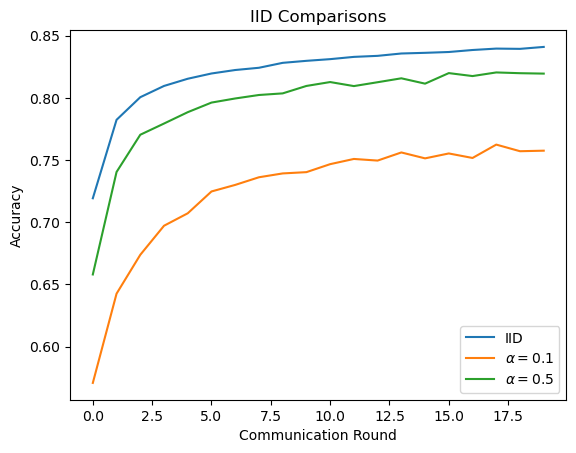

In [16]:
fps_to_cmpr = ["../records/trial1/17_06_15_56.dat", 
                     "../records/trial2/14_06_01_57.dat",
                    "../records/trial3/24_06_04_45.dat"]
labels = ["IID", r"$\alpha=0.1$", r"$\alpha=0.5$"]
fps_to_cmpr = ["../" + fp for fp in fps_to_cmpr]
plot_multiple_accs(fps_to_cmpr, labels, save_path=None, title="IID Comparisons")

In [5]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.5.dat"
rec = open_dat(fp)
rec["testing_accuracy"]

[0.6532999873161316,
 0.7224999666213989,
 0.7925999760627747,
 0.7913999557495117,
 0.8163999915122986,
 0.8168999552726746,
 0.8184999823570251,
 0.823199987411499,
 0.8233000040054321,
 0.8366000056266785,
 0.8328999876976013,
 0.8283999562263489,
 0.8341999650001526,
 0.8424999713897705,
 0.8387999534606934,
 0.836899995803833,
 0.8434000015258789,
 0.8393999934196472,
 0.8411999940872192,
 0.8410999774932861]

In [12]:
main_st_fps = {
    0.5: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_1/26_06_11_03.dat", # 0.5
    0.1: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_2/26_06_11_31.dat", # 0.1
    -1: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_3/26_06_12_09.dat" # IID
}

main_st_recs = {alpha: open_dat(fp) for alpha, fp in main_st_fps.items()}

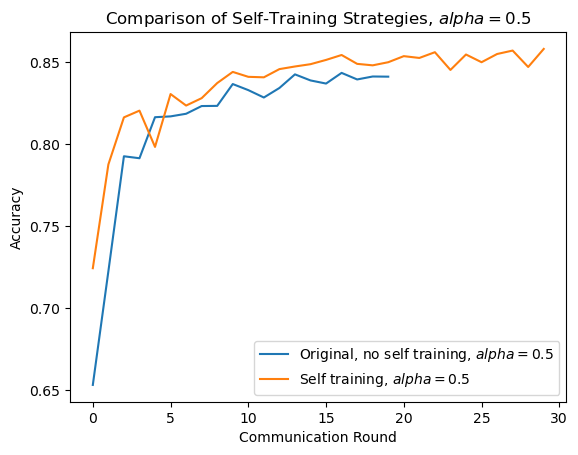

In [19]:
original_alpha05 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.5.dat")
plt.plot(original_alpha05["testing_accuracy"], label = "Original, no self training, $alpha=0.5$")
plt.plot(main_st_recs[0.5]["testing_accuracy"], label="Self training, $alpha=0.5$")
plt.title("Comparison of Self-Training Strategies, $alpha=0.5$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

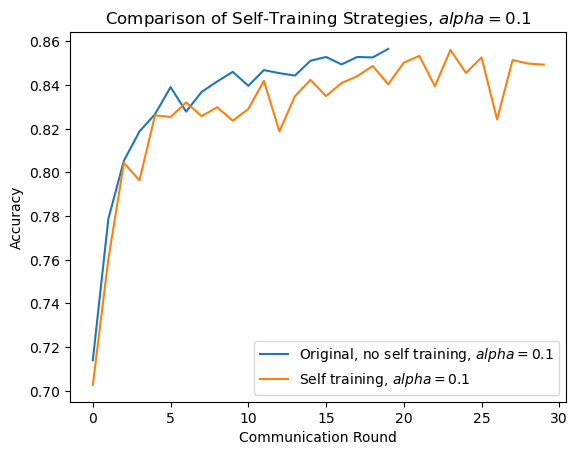

In [20]:
original_alpha01 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.1.dat")
plt.plot(original_alpha01["testing_accuracy"], label = "Original, no self training, $alpha=0.1$")
plt.plot(main_st_recs[0.1]["testing_accuracy"], label="Self training, $alpha=0.1$")
plt.title("Comparison of Self-Training Strategies, $alpha=0.1$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

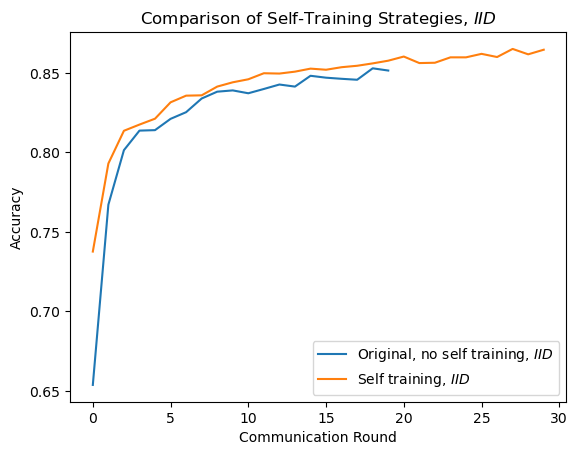

In [21]:
original_alpha01 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/iid_FAMNIST.dat")
plt.plot(original_alpha01["testing_accuracy"], label = "Original, no self training, $IID$")
plt.plot(main_st_recs[-1]["testing_accuracy"], label="Self training, $IID$")
plt.title("Comparison of Self-Training Strategies, $IID$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

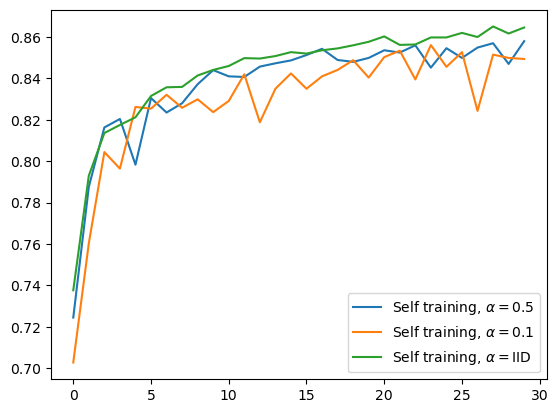

In [24]:
plt.plot(main_st_recs[0.5]["testing_accuracy"], label=r"Self training, $\alpha=0.5$")
plt.plot(main_st_recs[0.1]["testing_accuracy"], label=r"Self training, $\alpha=0.1$")
plt.plot(main_st_recs[-1]["testing_accuracy"], label=r"Self training, $\alpha=\text{IID}$")
plt.legend()
plt.show()

[0.11009999 0.64595798 0.70572832 0.72882932 0.74655565 0.75563098
 0.76132231 0.76459965 0.76918331 0.77269831 0.77945531 0.77952098
 0.78183565 0.78206131 0.78643431 0.78712831 0.78882398 0.78873431
 0.79139598 0.79443365 0.79456598]
Max Acc: 0.7945659806330999
Final Acc: 0.7945659806330999
Acc after averaging all models: 0.85589998960495


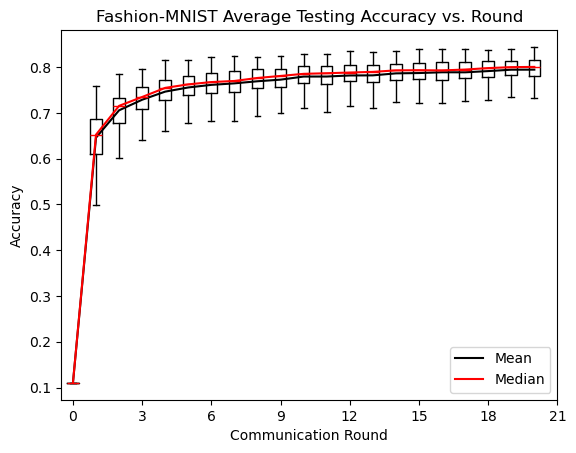

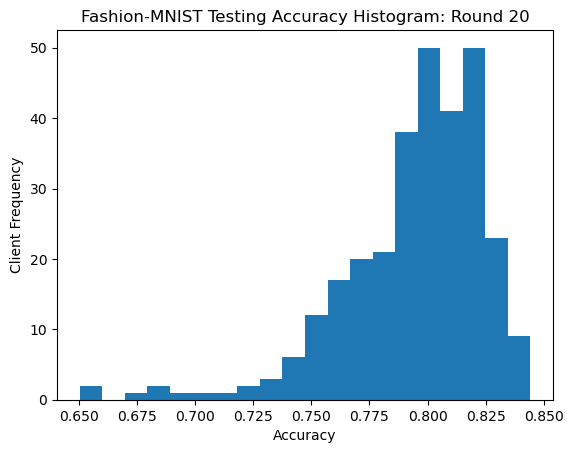

In [52]:
fp = "../../records/trial13/27_06_01_23.dat"
rec = open_dat(fp)
# plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, save_path="../../records/trial13/trial13_acc.png")
# plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trial13/trial13_hist.png")
# save_results_intxt(rec, "Fashion-MNIST", f"../../records/trial13/trial13_results.txt", config, logger)

[0.0635     0.67123265 0.74370598 0.76812031 0.78235798 0.78792998
 0.79675631 0.79957798 0.80472331 0.80540731 0.80661298 0.81091731
 0.81388098 0.81283598 0.81771865 0.81483598 0.81620731 0.81859431
 0.82001198 0.82233298 0.82336331 0.82138998 0.82257598 0.82498898
 0.82556598 0.82490898 0.82680165 0.82651998 0.82718198 0.82869865
 0.82949831]
Max Acc: 0.8294983114798864
Final Acc: 0.8294983114798864
Acc after averaging all models: 0.8618999719619751


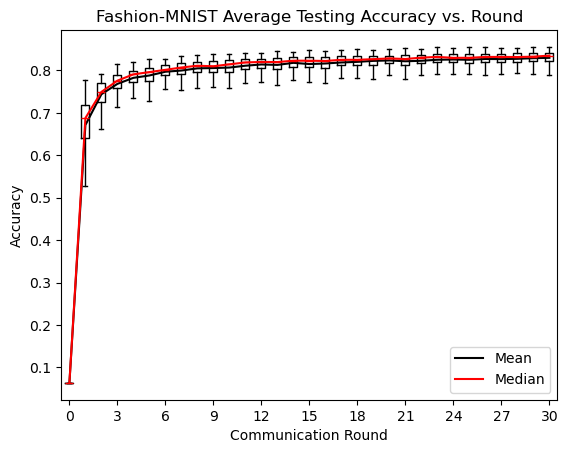

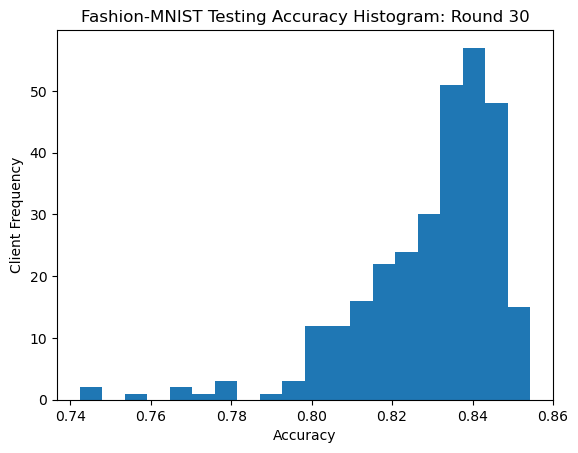

In [53]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial14/28_06_07_16.dat"
rec = open_dat(fp)
plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, save_path="../../records/trial14/trial14_acc.png")
plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trial14/trial14_hist.png")
save_results_intxt(rec, "Fashion-MNIST", f"../../records/trial14/trial14_results.txt", config, logger)

In [19]:
config_file = "config_random_graph_st.yaml"
config = load_config(config_file)
logger = init_logger(config)
model = init_model(config, logger)
record = init_record(config, model)

if config.device == "cuda":
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

current_path = os.getcwd()
if current_path.endswith("notebooks"):
    config.train_data_dir = "../" + config.train_data_dir
    config.test_data_dir = "../" + config.test_data_dir

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trial16/train.log


[0.1417     0.68287798 0.75195632 0.77286198 0.78357398 0.79369831
 0.79778698 0.80012832 0.80536365 0.80549431 0.80987498 0.81210898
 0.81312665 0.81476265 0.81593931 0.81738098 0.81747965 0.81751298
 0.82040198 0.82222065 0.82180231 0.82290664 0.82425364 0.82634798
 0.82588931 0.82572831 0.82674965 0.82754631 0.82821798 0.82611365
 0.82850965]
Max Acc: 0.8285096460580825
Final Acc: 0.8285096460580825
Acc after averaging all models: 0.8622999787330627


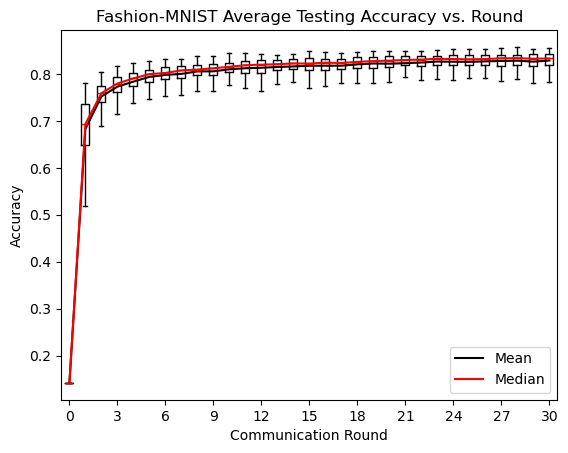

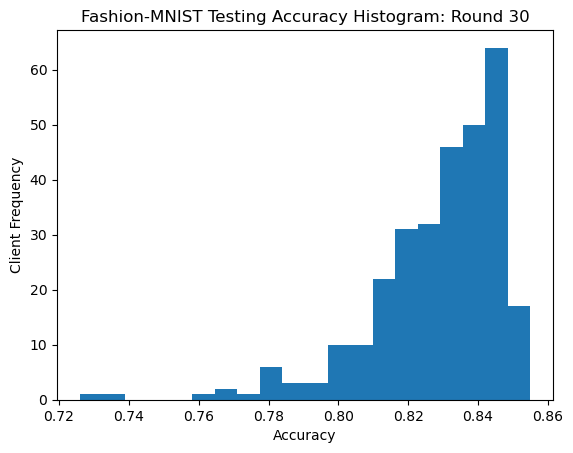

In [37]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial16/01_07_05_25.dat"
rec = open_dat(fp)
plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, save_path="../../records/trial16/trial16_acc.png")
plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trial16/trial16_hist.png")
save_results_intxt(rec, "Fashion-MNIST", f"../../records/trial16/trial16_results.txt", config, logger)

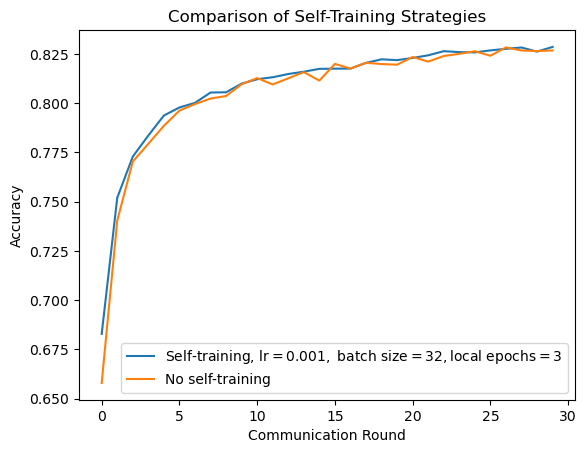

In [39]:
fps =  ["/home/gathomp3/Deep_Learning/NeuralTangent/records/trial16/01_07_05_25.dat", "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial3/24_06_04_45.dat"]
rec = open_dat(fps[0])
plt.plot(np.array(rec["testing_accuracy"]).mean(axis=1)[1:], label=r"Self-training, $\text{lr}=0.001,\ \text{batch size}=32, \text{local epochs}=3$")
rec = open_dat(fps[1])
plt.plot(np.array(rec["testing_accuracy"]).mean(axis=1), label="No self-training")
plt.legend()
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.title("Comparison of Self-Training Strategies")
plt.show()

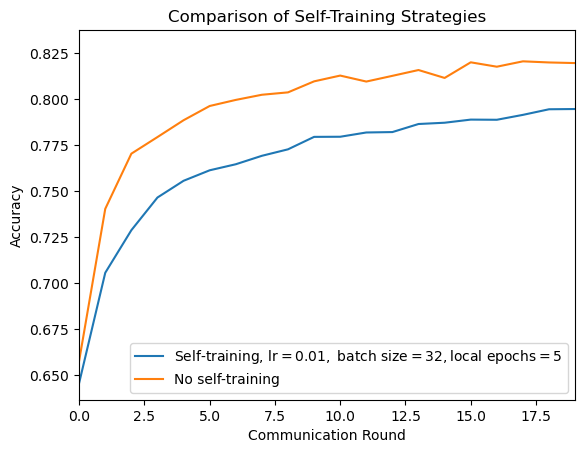

: 

In [45]:
fps =  ["/home/gathomp3/Deep_Learning/NeuralTangent/records/trial13/27_06_01_23.dat", "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial3/24_06_04_45.dat"]
rec = open_dat(fps[0])
plt.plot(np.array(rec["testing_accuracy"]).mean(axis=1)[1:], label=r"Self-training, $\text{lr}=0.01,\ \text{batch size}=32, \text{local epochs}=5$")
rec = open_dat(fps[1])
plt.plot(np.array(rec["testing_accuracy"]).mean(axis=1), label="No self-training")
plt.legend()
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.xlim(0, 19)
plt.title("Comparison of Self-Training Strategies")
plt.show()

In [6]:
setup("config_random_graph_st.yaml")
fps = ["/home/gathomp3/Deep_Learning/NeuralTangent/records/trial1/17_06_15_56.dat", 
       "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial2/14_06_01_57.dat",
       "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial3/24_06_04_45.dat"]
recs = [open_dat(fp) for fp in fps]

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Creating config from filepath:  /home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils
/home/gathomp3/Deep_Learning/NeuralTangent/records/trial16/train.log


### IID

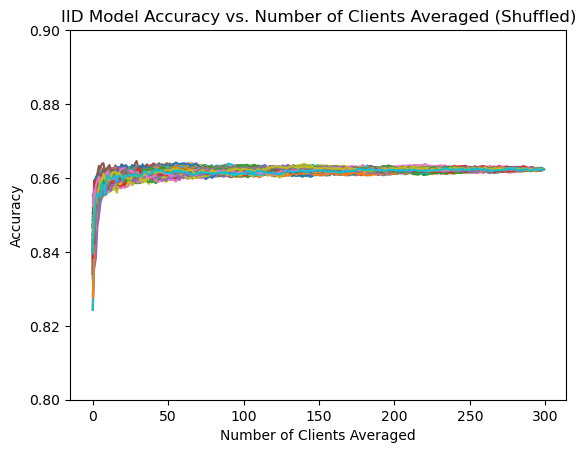

In [104]:
for i in range(100):
    plt.plot(_get_acc_vs_avg(recs[0], config, logger, max_num=300, shuffle=True), label="IID")
    plt.title("IID Model Accuracy vs. Number of Clients Averaged (Shuffled)")
    plt.xlabel("Number of Clients Averaged")
    plt.ylabel("Accuracy")
    plt.ylim(0.80, 0.90)
    # plt.legend()
    # plt.show()

### $\alpha = 0.1$

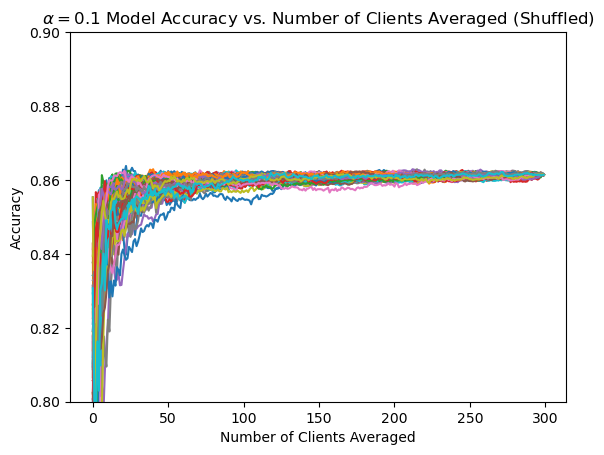

In [105]:
for i in range(100):
    plt.plot(_get_acc_vs_avg(recs[1], config, logger, max_num=300, shuffle=True), label="IID")
    plt.title("$\\alpha = 0.1$ Model Accuracy vs. Number of Clients Averaged (Shuffled)")
    plt.xlabel("Number of Clients Averaged")
    plt.ylabel("Accuracy")
    plt.ylim(0.80, 0.90)
    # plt.legend()
    # plt.show()

### $\alpha = 0.5$

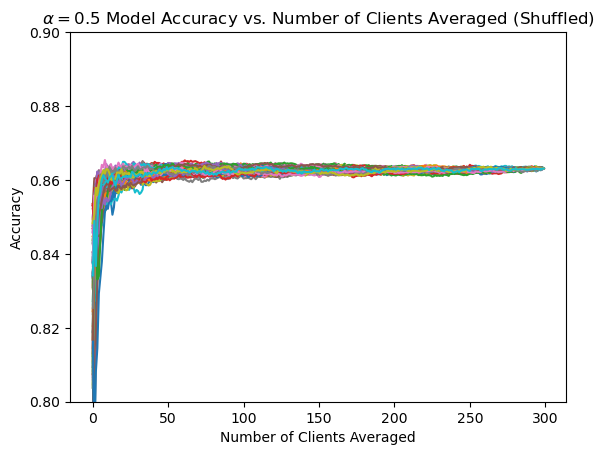

In [106]:
for i in range(100):
    plt.plot(_get_acc_vs_avg(recs[2], config, logger, max_num=300, shuffle=True), label="IID")
    plt.title("$\\alpha = 0.5$ Model Accuracy vs. Number of Clients Averaged (Shuffled)")
    plt.xlabel("Number of Clients Averaged")
    plt.ylabel("Accuracy")
    plt.ylim(0.80, 0.90)
    # plt.legend()
    # plt.show()